In [1]:
import lightning as L
import numpy as np
import torch
import torch.nn as nn
from torchdiffeq import odeint
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import copy
from lightning.pytorch.callbacks import Callback

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# maps x,t,mu to u (pde solution)
def burgers_exact_eqn(x, t, mu):
    pi = torch.pi
    e1 = torch.exp(-(pi**2)*t/mu)
    e4 = torch.exp(-(4*pi**2)*t/mu)
    
    num = 0.25 * e1 * torch.sin(pi*x) + e4 * torch.sin(2*pi*x)
    den = 1.0 + 0.25 * e1 * torch.cos(pi*x) + 0.5 * e4 * torch.cos(2*pi*x)

    return (2*pi/mu)*(num/den)

def generate_burgers_solution_grid(mu_values, n_x, n_t, T_final=1.0):
    # create range of values as vectors
    x_axis = torch.linspace(0.0, 2.0, n_x)          # (nx,)
    t_axis = torch.linspace(0.0, T_final, n_t + 1)  # (nt+1,)
    mu_axis = torch.tensor(mu_values)                # (nmu,)

    # create full grid across all space, time, parameters
    X_grid = x_axis[None, None, :].expand(mu_axis.shape[0], t_axis.shape[0], x_axis.shape[0])
    T_grid = t_axis[None, :, None].expand_as(X_grid)
    Mu_grid = mu_axis[:, None, None].expand_as(X_grid)

    # evaluate solution on full grid
    u_grid = burgers_exact_eqn(X_grid, T_grid, Mu_grid)

    # enforce boundary conditions
    u_grid[:, :, 0]  = 0.0
    u_grid[:, :, -1] = 0.0

    return x_axis, t_axis, mu_axis, u_grid

In [4]:
# samples (x, t, mu) with target u from the solution grid
class BurgersExactDataset(Dataset):
    def __init__(self, x_axis, t_axis, mu_axis, u_grid, n_samples=200000):
        super().__init__()
        # coordinate axes
        self.x_axis = x_axis
        self.t_axis = t_axis
        self.mu_axis = mu_axis

        # solution field
        self.u_grid = u_grid

        # grid sizes
        self.n_mu, self.n_tp1, self.n_x = u_grid.shape

        self.n_samples = int(n_samples)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # sample random axis indices
        i_mu = torch.randint(0, self.n_mu, (1,)).item()
        i_t = torch.randint(1, self.n_tp1, (1,)).item()
        i_x = torch.randint(0, self.n_x, (1,)).item()

        # coordinates at those indices
        x_coord = self.x_axis[i_x]
        t_coord = self.t_axis[i_t]
        mu_val = self.mu_axis[i_mu]

        # target solution value
        y = self.u_grid[i_mu, i_t, i_x]

        return x_coord, t_coord, mu_val, y

In [5]:
class BurgersPhysicsDataset(Dataset):
    def __init__(self, mus, n_samples):
        super().__init__()
        self.mus = torch.tensor(mus)
        self.n_mu = len(self.mus)
        self.n_samples = n_samples

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        i_mu = torch.randint(0, self.n_mu, (1,)).item()
        mu_val = self.mus[i_mu]

        eps = 1e-6
        x_coord = torch.clamp(torch.rand(())*2.0, eps, 2.0-eps)
        t_coord = torch.clamp(torch.rand(()), eps, 1.0)

        return x_coord, t_coord, mu_val

In [6]:
# pass inputs through fourier features
class FourierFeatures(nn.Module):
    def __init__(self, n_freqs=16, max_freq=10.0):
        super().__init__()
        freqs = torch.linspace(1.0, max_freq, n_freqs)
        self.register_buffer("freqs", freqs)

    def forward(self, x): 
        if x.dim() == 1:
            x = x[:, None]
        w = x * self.freqs[None, :] * torch.pi # (B, n_freq)
        return torch.cat([torch.sin(w), torch.cos(w)], dim=-1) # (B, 2*n_freq)

In [7]:
# decoder that takes in x and alpha and outputs u
class Decoder(nn.Module):
    def __init__(self, latent_dim=10, n_freqs=16, max_freq=10.0, hidden=128, n_hidden_layers=3):
        super().__init__()
        self.ff = FourierFeatures(n_freqs=n_freqs, max_freq=max_freq)
        dim = 2 * n_freqs + latent_dim
        
        layers = []
        for _ in range(n_hidden_layers):
            layers += [nn.Linear(dim, hidden), nn.Tanh()]
            dim = hidden
        layers += [nn.Linear(dim, 1)]
        
        self.model = nn.Sequential(*layers)

    def forward(self, x, alpha):
        phi_x = self.ff(x) # (B, 2*n_freq)
        inputs = torch.cat([phi_x, alpha], dim=-1)
        u = self.model(inputs) # (B, 1)
        return u.squeeze(-1)

In [8]:
# parameterized neural ode that takes in mu, alpha and t and outputs time derivative of alpha
class PNODEFunc(nn.Module):
    def __init__(self, latent_dim=10, hidden=128, n_hidden_layers=2):
        super().__init__()
        dim = latent_dim + 2 # alpha + t + mu

        layers = []
        for _ in range(n_hidden_layers):
            layers += [nn.Linear(dim, hidden), nn.Tanh()]
            dim = hidden
        layers += [nn.Linear(dim, latent_dim)]

        self.model = nn.Sequential(*layers)

    def forward(self, alpha, t, mu):
        B = alpha.shape[0]
        t_col = t.expand(B, 1)
        mu_col = mu.view(B, 1)
        inputs = torch.cat([alpha, t_col, mu_col], dim=-1)
        return self.model(inputs)

In [9]:
class PNODE(nn.Module):
    def __init__(self, func: PNODEFunc, latent_dim=10):
        super().__init__()
        self.func = func
        self.latent_dim = latent_dim

    def forward(self, t, alpha, mu):
        B = alpha.shape[0]
        t_vec = t.expand(B, 1)
        if mu.dim() == 1:
            mu = mu.unsqueeze(-1)
        return self.func(alpha, t_vec, mu) 

In [10]:
def phi_xt(x, t):
    return x * (2.0-x) * t

def g_ic(x, t, mu):
    return burgers_exact_eqn(x, torch.zeros_like(t), mu)

def u_constrained(decoder, x, t, alpha, mu):
    return g_ic(x, t, mu) + phi_xt(x, t) * decoder(x, alpha)

In [11]:
def data_loss_fn(model, batch):
    x, t, mu, y = batch
    pred = model(x, t, mu)
    return torch.mean((pred-y)**2)

def physics_loss_fn(model, batch):
    x, t, mu = batch
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)
    mu = mu.clone().detach()

    alpha, f_theta = model.get_latents(t, mu)
    D = model.decoder(x, alpha)
    phi = phi_xt(x, t)
    g = g_ic(x, t, mu)

    dt_phi = torch.autograd.grad(phi.sum(), t, create_graph=True)[0]
    dt_g = torch.zeros_like(t)

    u_t_explicit = dt_g + D * dt_phi
    grad_alpha_D = torch.autograd.grad(D.sum(), alpha, create_graph=True)[0]
    chain_rule_term = (grad_alpha_D * f_theta).sum(dim=1)
     
    u_t_implicit = phi * chain_rule_term
    u_t = u_t_explicit + u_t_implicit
    u_full = g + phi * D
    u_x = torch.autograd.grad(u_full.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

    residual = u_t + u_full * u_x - (1.0/mu) * u_xx

    return torch.mean(residual**2)

In [12]:
class CNFROM(nn.Module):
    def __init__(self, decoder: Decoder, pnode: PNODE):
        super().__init__()
        self.decoder = decoder
        self.pnode = pnode

    def get_latents(self, t, mu, T=1.0, steps=101):
        device = mu.device
        
        t_grid = torch.linspace(0.0, T, steps, device=device)
        alpha0 = torch.zeros(mu.shape[0], self.pnode.latent_dim, device=device)

        def func(t_, a_):
            return self.pnode(t_, a_, mu)
        alpha_trajectory = odeint(func, alpha0, t_grid, method="rk4")

        # interpolate to t
        dt = t_grid[1] - t_grid[0]
        indices = torch.floor(t/dt).long().clamp(0, steps-2)
        trajectory = alpha_trajectory.permute(1, 0, 2)
        batch_ids = torch.arange(t.shape[0], device=device)
        alpha_start = trajectory[batch_ids, indices]
        alpha_end = trajectory[batch_ids, indices+1]

        t_start = t_grid[indices]
        ratio = ((t-t_start)/dt).unsqueeze(-1)
        alpha_interp = alpha_start + ratio * (alpha_end - alpha_start)

        f_theta = self.pnode(t.unsqueeze(-1), alpha_interp, mu)

        return alpha_interp, f_theta

    def forward(self, x, t, mu):
        alpha, _ = self.get_latents(t, mu)   
        u = u_constrained(self.decoder, x, t, alpha, mu) 
        return u

In [13]:
class Model(L.LightningModule):
    def __init__(self, model, lr=1e-3, mode="data"):
        super().__init__()
        self.model = model
        self.lr = lr
        self.mode = mode

        self.loss_hist = {"data": [], "physics": []}
        self.epoch_loss_hist = {"data": [], "physics": []}
        self.epoch_losses = []
    
    def training_step(self, batch, batch_idx):
        if self.mode == "data":
            loss = data_loss_fn(self.model, batch) 
        else:
            loss = physics_loss_fn(self.model, batch)
            
        self.log(f"train_loss_{self.mode}", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        self.epoch_losses.append(loss.detach())
        
        return loss

    def configure_optimizers(self):
        if self.mode == "data":
            return torch.optim.Adam(self.model.parameters(), lr=self.lr)
        else:
            return torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def on_train_epoch_end(self):
        if len(self.epoch_losses) > 0:
            mean_loss = torch.stack(self.epoch_losses).mean().item()
            self.epoch_loss_hist[self.mode].append(mean_loss)
        self.epoch_losses = []

In [14]:
mu_train = [20.0, 30.0, 40.0]
mu_test  = [15.0, 25.0]
mu_all = sorted(mu_train+mu_test)
n_x = 64
n_t = 100
T_f = 1.0

In [15]:
x_axis, t_axis, mu_axis, u_grid = generate_burgers_solution_grid(mu_train, n_x, n_t, T_f)

exact_train_dataset = BurgersExactDataset(x_axis, t_axis, mu_axis, u_grid, n_samples=50000)
exact_train_loader = DataLoader(exact_train_dataset, batch_size=256, shuffle=True)

physics_train_dataset = BurgersPhysicsDataset(mu_all, n_samples=50000)
physics_train_loader = DataLoader(physics_train_dataset, batch_size=256, shuffle=True)

In [22]:
latent_dim = 10
max_epochs_data = 500
max_epochs_physics = 500
lr = 1e-3

In [23]:
decoder = Decoder(latent_dim=latent_dim)
pnode_func = PNODEFunc(latent_dim=latent_dim)
pnode = PNODE(pnode_func, latent_dim=latent_dim)
cnf = CNFROM(decoder, pnode)
model = Model(cnf, mode="data") 

# Data + Physics

In [24]:
model.mode = "data"
L.Trainer(accelerator="gpu", devices=1, max_epochs=max_epochs_data).fit(model, exact_train_loader)

pretrained_cnf = copy.deepcopy(model)

# for p in model.model.decoder.parameters():
#     p.requires_grad = False
model.mode = "physics"
L.Trainer(accelerator="gpu", devices=1, max_epochs=max_epochs_physics).fit(model, physics_train_loader)

finetuned_cnf = copy.deepcopy(model)

data_losses = model.loss_hist["data"]
phys_losses = model.loss_hist["physics"]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | CNFROM | 58.1 K | train
-----------------------------------------
58.1 K    Trainable params
0         Non-trainable params
58.1 K    Total params
0.232     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...

KeyboardInterrupt



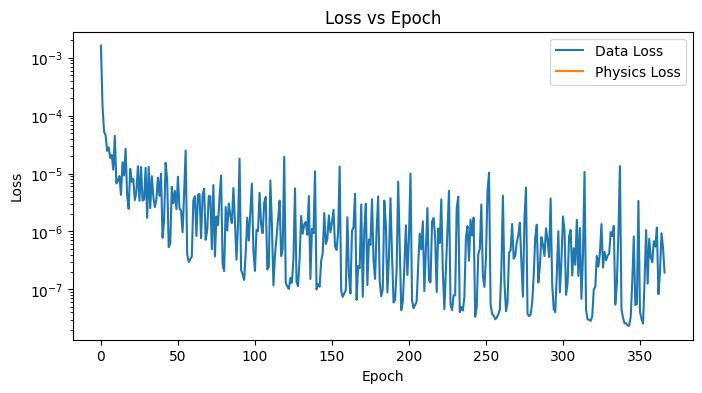

In [25]:
data_loss = model.epoch_loss_hist["data"]
physics_loss = model.epoch_loss_hist["physics"]

plt.figure(figsize=(8,4))
plt.plot(data_loss, label="Data Loss")
plt.plot(np.arange(len(data_loss), len(data_loss)+len(physics_loss)),physics_loss, label="Physics Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

In [26]:
@torch.no_grad()
def plot_heatmap_compare(cnf_pre, cnf_fin, mu0=20.0, n_x=128, n_t=128, T=1.0):
    x = torch.linspace(0.0, 2.0, n_x, device=next(cnf_pre.parameters()).device)
    t = torch.linspace(0.0, T, n_t, device=x.device)
    X, Tt = torch.meshgrid(x, t, indexing="xy")
    x_flat = X.reshape(-1)
    t_flat = Tt.reshape(-1)
    mu_flat = torch.full_like(x_flat, float(mu0))

    u_true = burgers_exact_eqn(X, Tt, torch.full_like(X, float(mu0)))
    u_pre = cnf_pre(x_flat, t_flat, mu_flat).reshape_as(X)
    u_fin = cnf_fin(x_flat, t_flat, mu_flat).reshape_as(X)

    err_pre = (u_pre - u_true).abs()
    err_fin = (u_fin - u_true).abs()
    def rel_L2(u_pred, u_true):
        return (torch.norm(u_pred - u_true) / (torch.norm(u_true) + 1e-12)).item()

    rel_pre = rel_L2(u_pre, u_true)
    rel_fin = rel_L2(u_fin, u_true)
    u_min = torch.min(torch.stack([u_true.min(), u_pre.min(), u_fin.min()])).item()
    u_max = torch.max(torch.stack([u_true.max(), u_pre.max(), u_fin.max()])).item()
    e_min = 0.0
    e_max = torch.max(torch.stack([err_pre.max(), err_fin.max()])).item()

    def show(ax, M, title, vmin=None, vmax=None):
        im = ax.imshow(
            M.T.detach().cpu(),
            origin="lower",
            aspect="auto",
            extent=[x.min().item(), x.max().item(), t.min().item(), t.max().item()],
            vmin=vmin,
            vmax=vmax,
        )
        ax.set_xlabel("Space x")
        ax.set_ylabel("Time t")
        ax.set_title(title)
        return im

    fig, axs = plt.subplots(2, 3, figsize=(14, 7))

    im0 = show(axs[0,0], u_true, "True u(x,t)", vmin=u_min, vmax=u_max)
    im1 = show(axs[0,1], u_pre,  f"Pretrained Prediction\nRel L2={rel_pre:.3f}", vmin=u_min, vmax=u_max)
    im2 = show(axs[0,2], u_fin,  f"Finetuned Prediction\nRel L2={rel_fin:.3f}", vmin=u_min, vmax=u_max)

    axs[1,0].axis("off")
    im4 = show(axs[1,1], err_pre, "Pretrained Error", vmin=e_min, vmax=e_max)
    im5 = show(axs[1,2], err_fin, "Finetuned Error", vmin=e_min, vmax=e_max)

    fig.colorbar(im0, ax=axs[0,:], fraction=0.02)
    fig.colorbar(im4, ax=axs[1,1:], fraction=0.02)
    plt.tight_layout()
    plt.show()

In [ ]:
mu = 20.0
cnf_pre = pretrained_cnf.model
cnf_fin = finetuned_cnf.model
plot_heatmap_compare(cnf_pre, cnf_fin, mu0=mu)